# Transfer Learning

In practice, very few people train an entire Convolutional Network from scratch (with random initialization), because it is relatively rare to have a dataset of sufficient size. Instead, it is common to pretrain a ConvNet on a very large dataset (e.g. ImageNet, which contains 1.2 million images with 1000 categories), and then use the ConvNet either as an initialization or a fixed feature extractor for the task of interest. The major Transfer Learning scenarios look as follows:

**ConvNet as fixed feature extractor**:
Take a ConvNet pretrained on ImageNet, remove the last fully-connected layer, then treat the rest of the ConvNet as a fixed feature extractor for the new dataset.

**Fine-tuning the ConvNet**: The second strategy is to not only replace and retrain the classifier on top of the ConvNet on the new dataset, but to also fine-tune the weights of the pretrained network by continuing the backpropagation. It is possible to fine-tune all the layers of the ConvNet, or it’s possible to keep some of the earlier layers fixed (due to overfitting concerns) and only fine-tune some higher-level portion of the network.

## When and how to fine-tune?

How do you decide what type of transfer learning you should perform on a new dataset? Let's continue the CovNet example. Keeping in mind that ConvNet features are more generic in early layers and more original-dataset-specific in later layers, here are some common rules of thumb for navigating the major scenarios:

**New dataset is small and similar to original dataset**: Since the data is small, it is not a good idea to fine-tune the ConvNet due to overfitting concerns. We expect higher-level features in the ConvNet to be relevant to this dataset as well. Hence, the best idea might be to train a linear classifier on the CNN codes.

**New dataset is large and similar to the original dataset**: Since we have more data, we can have more confidence that we won’t overfit if we were to try to fine-tune through the full network.

**New dataset is small but very different from the original dataset** Since the data is small, it is likely best to only train a linear classifier. Since the dataset is very different, it might not be best to train the classifier form the top of the network, which contains more dataset-specific features. Instead, it might work better to train the classifier from activations somewhere earlier in the network.

**New dataset is large and very different from the original dataset** Since the dataset is very large, we may expect that we can afford to train a ConvNet from scratch. However, in practice it is very often still beneficial to initialize with weights from a pretrained model. In this case, we would have enough data and confidence to fine-tune through the entire network.

## Additional Note:

If you wish to use a pretrained network, you may be slightly constrained in terms of the architecture you can use for your new dataset. For example, you can’t arbitrarily take out Conv layers from the pretrained network. However, some changes are straight-forward.

It’s common to use a smaller learning rate for ConvNet weights that are being fine-tuned, in comparison to the (randomly-initialized) weights for the new linear classifier that computes the class scores of your new dataset. This is because we expect that the ConvNet weights are relatively good, so we don’t wish to distort them too quickly and too much.

## Implementation:

Let's try to build an ant/bee image classifier

**Library Import**

In [1]:
import sys
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

cudnn.benchmark = True

**Data Loading and Normalisation**

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = '/content/drive/My Drive/hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


**Visualising Data**

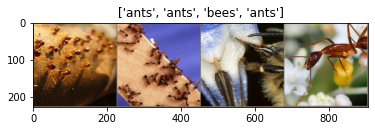

In [5]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

**Finetuning the Model**

In [6]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

**Data Visualisation**

In [7]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

**Loading resnet18**

In [8]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

**Training the model**

In [9]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 0.5177 Acc: 0.7418
val Loss: 0.2296 Acc: 0.9020

Epoch 1/24
----------
train Loss: 0.7238 Acc: 0.7377
val Loss: 0.5198 Acc: 0.8366

Epoch 2/24
----------
train Loss: 0.4811 Acc: 0.8320
val Loss: 0.4136 Acc: 0.8105

Epoch 3/24
----------
train Loss: 0.6561 Acc: 0.7582
val Loss: 0.4086 Acc: 0.8824

Epoch 4/24
----------
train Loss: 0.6522 Acc: 0.7787
val Loss: 0.2516 Acc: 0.8954

Epoch 5/24
----------
train Loss: 0.5252 Acc: 0.7910
val Loss: 0.2834 Acc: 0.9020

Epoch 6/24
----------
train Loss: 0.3712 Acc: 0.8525
val Loss: 0.3225 Acc: 0.8889

Epoch 7/24
----------
train Loss: 0.2439 Acc: 0.8893
val Loss: 0.2285 Acc: 0.9216

Epoch 8/24
----------
train Loss: 0.2578 Acc: 0.8934
val Loss: 0.2098 Acc: 0.9216

Epoch 9/24
----------
train Loss: 0.2425 Acc: 0.8852
val Loss: 0.2134 Acc: 0.9216

Epoch 10/24
----------
train Loss: 0.2517 Acc: 0.8852
val Loss: 0.1866 Acc: 0.9412

Epoch 11/24
----------
train Loss: 0.2911 Acc: 0.8607
val Loss: 0.2043 Acc: 0.9346

Ep

**Finetuning results visualized**

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


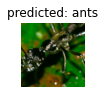

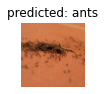

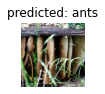

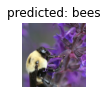

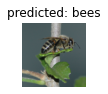

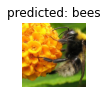

In [17]:
visualize_model(model_ft)

**Fixed feature extraction**

In [18]:
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


**Training the model**

In [19]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.6088 Acc: 0.6516
val Loss: 0.2795 Acc: 0.9020

Epoch 1/24
----------
train Loss: 0.5942 Acc: 0.7746
val Loss: 0.1905 Acc: 0.9281

Epoch 2/24
----------
train Loss: 0.3924 Acc: 0.8402
val Loss: 0.2047 Acc: 0.9346

Epoch 3/24
----------
train Loss: 0.4925 Acc: 0.7582
val Loss: 0.2053 Acc: 0.9216

Epoch 4/24
----------
train Loss: 0.4290 Acc: 0.8402
val Loss: 0.4478 Acc: 0.8235

Epoch 5/24
----------
train Loss: 0.7226 Acc: 0.7377
val Loss: 0.1956 Acc: 0.9346

Epoch 6/24
----------
train Loss: 0.4833 Acc: 0.8033
val Loss: 0.3487 Acc: 0.8889

Epoch 7/24
----------
train Loss: 0.3622 Acc: 0.8074
val Loss: 0.1857 Acc: 0.9412

Epoch 8/24
----------
train Loss: 0.3270 Acc: 0.8525
val Loss: 0.1999 Acc: 0.9477

Epoch 9/24
----------
train Loss: 0.3224 Acc: 0.8525
val Loss: 0.2342 Acc: 0.9346

Epoch 10/24
----------
train Loss: 0.3226 Acc: 0.8689
val Loss: 0.1867 Acc: 0.9346

Epoch 11/24
----------
train Loss: 0.2881 Acc: 0.8893
val Loss: 0.2332 Acc: 0.9216

Ep

**Feature extraction visualised**

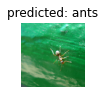

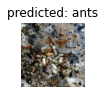

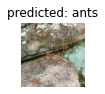

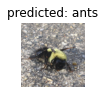

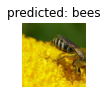

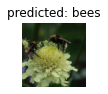

In [20]:
visualize_model(model_conv)

## Try it yourself

Build a number classifier (similar to the example done in CNN/Autoencoder tutorial) using tranfer learning. Analyse the perform difference between the two learning techniques for differently sized training sets (choose subsets of complete dataset).